In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e1.pth'

In [5]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.1
cfg.TRACK.WINDOW_INFLUENCE = float(np.power(0.42, 0.333))

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [7]:
def _iou(lhs, rhs):
    lhs = np.transpose(np.reshape(lhs, (-1, 4)), (1, 0))
    rhs = np.transpose(np.reshape(rhs, (-1, 4)), (1, 0))
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return (I / (A - I)).ravel()

In [17]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
   
    if ii > 10:
        break;
    
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

#     plt.imshow(t_img[:, :, ::-1])
#     rect = plt.Rectangle((rbb[0], rbb[1]),
#                          rbb[2],
#                          rbb[3], fill=False,
#                          edgecolor=[1, 0, 0], linewidth=3.5)
#     plt.gca().add_patch(rect)
    
#     gtbb = gt_seq[ii]
#     rect = plt.Rectangle((gtbb[0], gtbb[1]),
#                          gtbb[2],
#                          gtbb[3], fill=False,
#                          edgecolor=[0, 1, 0], linewidth=2.5)
#     plt.gca().add_patch(rect)
#     plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
#     plt.clf()

Tracking started, total 725 frames.


<Figure size 864x864 with 0 Axes>

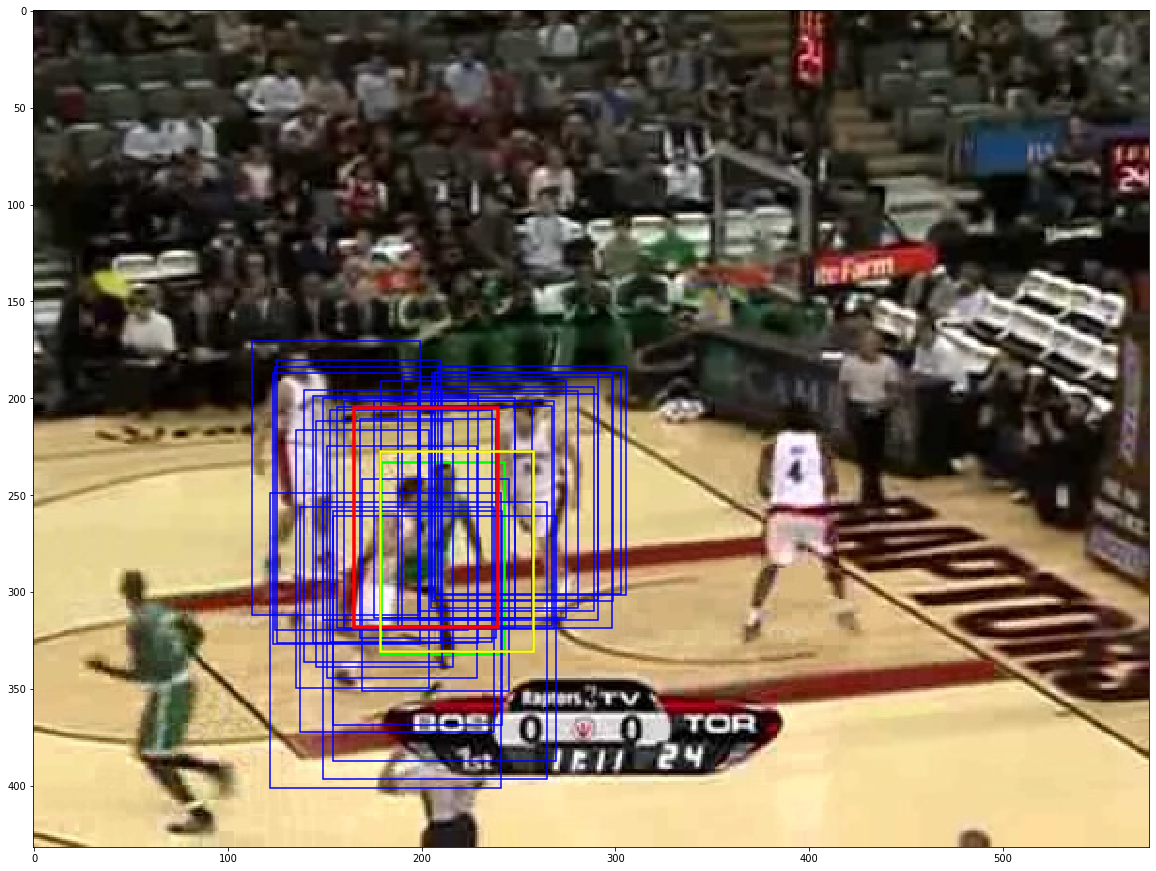

In [18]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

for pbb in res['pred_bbox']:
    rect = plt.Rectangle((pbb[0], pbb[1]),
                         pbb[2],
                         pbb[3], fill=False,
                         edgecolor=[0, 0, 1], linewidth=1.5)
    plt.gca().add_patch(rect)
    
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

midx = np.argmax(_iou(gt_bb, res['pred_bbox']))
bbb = res['pred_bbox'][midx]
rect = plt.Rectangle((bbb[0], bbb[1]),
                     bbb[2],
                     bbb[3], fill=False,
                     edgecolor=[1, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

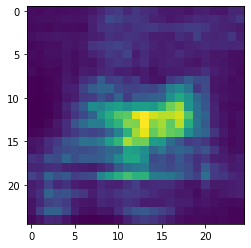

In [19]:
plt.imshow(res['ctr_rpn'].reshape((25, 25)))

In [11]:
np.max(res['ctr_rpn'])

0.20114362

In [12]:
res['pred_bbox']

array([[261.61053 , 190.94035 , 148.35182 , 151.6179  ],
       [218.06631 , 205.16454 , 160.1926  , 155.82132 ],
       [183.89487 , 206.63077 , 184.59363 , 155.0114  ],
       [193.87141 , 193.41568 , 183.32964 , 167.31708 ],
       [168.71231 , 211.58981 , 204.01448 , 166.26932 ],
       [183.6616  , 211.82587 , 204.17294 , 164.51445 ],
       [246.38544 , 206.82077 , 144.90138 , 148.53491 ],
       [235.95665 , 210.76505 , 157.26668 , 153.06102 ],
       [221.09091 , 255.57112 , 183.41866 , 147.54233 ],
       [209.44167 , 202.9406  , 175.01651 , 155.0109  ],
       [161.91615 , 209.3073  , 180.41182 , 155.75008 ],
       [237.78864 , 199.88455 , 157.86752 , 162.77652 ],
       [171.39977 , 208.59668 , 172.83682 , 151.4482  ],
       [217.78113 , 214.90982 , 166.72379 , 168.03938 ],
       [178.09068 , 204.62927 , 176.09007 , 161.39581 ],
       [273.73047 , 114.70732 , 158.32393 , 170.19234 ],
       [200.6191  , 251.37527 , 196.04529 , 157.53337 ],
       [215.33957 , 175.83887 ,

In [13]:
np.around(res['ctr_rcnn'], 3)

array([0.022, 0.012, 0.009, 0.008, 0.009, 0.009, 0.013, 0.013, 0.009,
       0.011, 0.011, 0.016, 0.011, 0.008, 0.007, 0.01 , 0.007, 0.005,
       0.006, 0.009, 0.007, 0.005, 0.007, 0.004, 0.003, 0.009, 0.011,
       0.012, 0.009, 0.007, 0.005, 0.006], dtype=float32)

In [14]:
np.around(res['cls_rcnn'], 3)

array([0.229, 0.064, 0.064, 0.08 , 0.067, 0.062, 0.096, 0.145, 0.102,
       0.073, 0.113, 0.172, 0.125, 0.065, 0.071, 0.094, 0.05 , 0.05 ,
       0.053, 0.105, 0.069, 0.063, 0.086, 0.025, 0.025, 0.112, 0.125,
       0.193, 0.131, 0.064, 0.082, 0.067], dtype=float32)

In [15]:
np.around(res['pscore'], 3)

array([0.785, 0.745, 0.691, 0.718, 0.669, 0.712, 0.774, 0.773, 0.696,
       0.744, 0.614, 0.781, 0.638, 0.737, 0.659, 0.581, 0.67 , 0.742,
       0.647, 0.756, 0.471, 0.593, 0.695, 0.247, 0.612, 0.452, 0.611,
       0.639, 0.407, 0.638, 0.759, 0.242], dtype=float32)

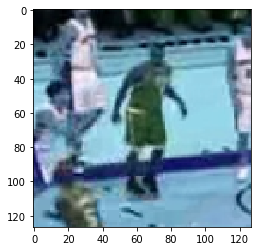

In [16]:
plt.imshow(tracker.img_z)

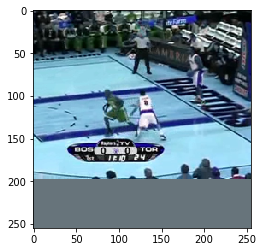

In [36]:
plt.imshow(tracker.img_x)

In [41]:
A = torch.zeros(3, 5)
B = torch.empty_like(A).normal_(0, 0.333)
C = torch.ones_like(A) * 2.0
C.pow_(B)

tensor([[0.7833, 1.1970, 0.8973, 0.8379, 1.0159],
        [1.0027, 1.0735, 0.8876, 1.3239, 0.9194],
        [0.8547, 0.9036, 0.6114, 0.7939, 0.6056]])

In [43]:
B

tensor([[-0.3523,  0.2594, -0.1564, -0.2552,  0.0228],
        [ 0.0039,  0.1023, -0.1720,  0.4048, -0.1212],
        [-0.2266, -0.1463, -0.7099, -0.3330, -0.7237]])